In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit

In [2]:
data = pd.read_csv(r'D:\ML\Занятие 9 Поиск выбросов и генерация новых признаков\train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
#Разделяем на тренировочные и тестовые данные

data_train, data_test, y_train, y_test = train_test_split(data.drop(columns='SalePrice'), data['SalePrice'], test_size=0.30, random_state=42)

In [5]:
#Находим категориальные признаки

categorials = list(data.dtypes[data.dtypes == object].index)

categorials_nunique = data_train[categorials].nunique()

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data_train[categorials] = data[categorials].fillna('nan')

In [6]:
#отфильтруем непрерывные признаки
integer = [f for f in data if f not in (categorials + ['ID', 'SalePrice'])]

In [7]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(data_train[categorials], columns=categorials)
dummy_test = pd.get_dummies(data_test[categorials], columns=categorials)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]

# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X_train = pd.concat([data_train[integer].fillna(-999), dummy_train], axis=1)

X_test = pd.concat([data_test[integer].fillna(-999), dummy_test], axis=1)

In [8]:
X_train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLD,BsmtFinType1_ALQ,Exterior2nd_AsbShng,RoofStyle_Hip,MiscFeature_Othr,Neighborhood_Sawyer,Exterior2nd_Plywood,BldgType_Duplex,SaleType_ConLw,BsmtFinType1_Rec
135,136,20,80.0,10400,7,6,1970,1970,288.0,0,...,0,0,0,1,0,0,1,0,0,0
1452,1453,180,35.0,3675,5,5,2005,2005,80.0,547,...,0,0,0,0,0,0,0,0,0,0
762,763,60,72.0,8640,7,5,2009,2009,0.0,24,...,0,0,0,0,0,0,0,0,0,0
932,933,20,84.0,11670,9,5,2006,2006,302.0,0,...,0,0,0,1,0,0,0,0,0,0
435,436,60,43.0,10667,7,6,1996,1996,0.0,385,...,0,0,0,0,0,0,0,0,1,0


## Random Forest

In [9]:
clf_rf = RandomForestRegressor()
clf_rf.fit(X_train, y_train)

RandomForestRegressor()

In [10]:
from sklearn.model_selection import cross_val_score

In [11]:
scores = cross_val_score(clf_rf, X_test, y_test, cv=10)

In [12]:
scores

array([0.8156384 , 0.74491959, 0.78016315, 0.79154042, 0.76182708,
       0.89801495, 0.86187526, 0.90293324, 0.88831814, 0.92836943])

In [13]:
# выведем наиболее важные признаки
imp = pd.Series(clf_rf.feature_importances_)

In [14]:
imp.index = pd.Series(X_train.columns)

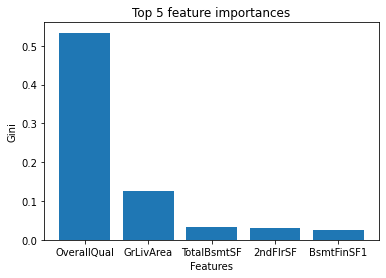

In [15]:
plt.title('Top 5 feature importances')
plt.xlabel('Features')
plt.ylabel('Gini')
plt.bar(imp.sort_values(ascending=False).head().index, imp.sort_values(ascending=False).head())
plt.show()

## Stacking (сначала классический)

In [16]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import RidgeCV

In [17]:
# Создаем стэккинг и обучаем его на наших данных - линейная модель - линейная регрессия, метод ближайшего соседа и дерево - нелин.
# модель второго уровня - ридж-регрессия
Regressor = StackingRegressor(
    [
        ('LinearRegression', LinearRegression()),
        ('KNeighborsRegressor', KNeighborsRegressor()),
        ('DecisionTree', DecisionTreeRegressor())
    ], RidgeCV())

In [18]:
Regressor.fit(X_train, y_train)

StackingRegressor(estimators=[('LinearRegression', LinearRegression()),
                              ('KNeighborsRegressor', KNeighborsRegressor()),
                              ('DecisionTree', DecisionTreeRegressor())],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

In [19]:
# видим, что stacking отработал лучше, чем отдельные модели, в него входящие
print(f'Score on train data {Regressor.score(X_train, y_train)}')
print(f'Score on test data {Regressor.score(X_test, y_test)}')

for i in Regressor.named_estimators:
    print(f'Score on train data with model {i} {Regressor.named_estimators_[i].score(X_train, y_train)}')
    print(f'Score on test data with model {i} {Regressor.named_estimators_[i].score(X_test, y_test)}')


Score on train data 0.9510408341530627
Score on test data 0.8579517908457556
Score on train data with model LinearRegression 0.922108540356243
Score on test data with model LinearRegression 0.8533836050579302
Score on train data with model KNeighborsRegressor 0.7419951520813983
Score on test data with model KNeighborsRegressor 0.6775304068635524
Score on train data with model DecisionTree 1.0
Score on test data with model DecisionTree 0.7318486617621955


## Stacking (с hold-out выборкой, т.е. blending)

In [20]:
# разделим train на 2 части
data_train1, data_hold_out, y_train1, y_hold_out = train_test_split(data_train, y_train, test_size=0.30, random_state=42)

In [21]:
#Находим категориальные признаки

categorials = list(data_train.dtypes[data_train.dtypes == object].index)

categorials_nunique = data_train1[categorials].nunique()

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data_train1[categorials] = data_train[categorials].fillna('nan')

C:\Users\79531\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [22]:
#отфильтруем непрерывные признаки
integer = [f for f in data_train if f not in (categorials + ['ID', 'SalePrice'])]

In [23]:
# Создаем дамми-переменные для категорий, пересекаем прзнаки как по новому train, так и по hold-out, так и по test-вой выборке изначальной
dummy_train1 = pd.get_dummies(data_train1[categorials], columns=categorials)
dummy_hold_out = pd.get_dummies(data_hold_out[categorials], columns=categorials)

dummy_cols = list(set(dummy_train1) & set(dummy_hold_out) & set(dummy_test))

dummy_train1 = dummy_train1[dummy_cols]
dummy_hold_out = dummy_hold_out[dummy_cols]
dummy_test = dummy_test[dummy_cols]

# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X_train1 = pd.concat([data_train1[integer].fillna(-999), dummy_train1], axis=1)

X_hold_out = pd.concat([data_hold_out[integer].fillna(-999), dummy_hold_out], axis=1)

X_test = pd.concat([data_test[integer].fillna(-999), dummy_test], axis=1)

### Обучаем три модели первого уровня на обучающей выборке, затем через обученные модели прогоняем выборку hold-out, полученные ответы делаем признаками для модели второго уровня - ридж-регрессии. Далее переходим к тестовым данным - отдаем их на вход обученным алгоритмам первого уровня - получаем ответы. Полученные ответы передаются на вход обученному мета-алгоритму, который и даст итоговое предсказание.

In [24]:
# обучаем первую модель на обучающей выборке
model1 = LinearRegression() 
model1.fit(X_train1, y_train1)

LinearRegression()

In [25]:
# получаем ответы
array1 = model1.predict(X_hold_out)

In [26]:
# через кросс-валидацию определяем качество модели
scores_lin_reg = cross_val_score(model1, X_hold_out, y_hold_out, cv=10)[1]
scores_lin_reg

0.13184499841829334

In [27]:
# обучаем вторую модель на обучающей выборке
model2 = KNeighborsRegressor()
model2.fit(X_train1, y_train1)

KNeighborsRegressor()

In [28]:
# получаем ответы для второй модели
array2 = model2.predict(X_hold_out)

In [29]:
# через кросс-валидацию определяем качество модели
scores_KNeighbor = cross_val_score(model2, X_hold_out, y_hold_out, cv=10).mean()
scores_KNeighbor

0.5243122339545987

In [30]:
# обучаем третью модель на обучающей выборке
model3 = KNeighborsRegressor()
model3.fit(X_train1, y_train1)

KNeighborsRegressor()

In [31]:
# получаем ответы
array3 = model3.predict(X_hold_out)

In [32]:
# через кросс-валидацию определяем качество модели
scores_DecisionTree = cross_val_score(model3, X_hold_out, y_hold_out, cv=10).mean()
scores_DecisionTree

0.5243122339545987

In [33]:
# объединим ответы трех моделей в новую выборку, которую подадим на вход мета-модели
df = pd.DataFrame(array1, columns = ['array1'])
df['array2'] = array2
df['array3'] = array3
df.head()

,array1,array2,array3
0,227194.892305,271483.8,271483.8
1,137225.895299,149390.0,149390.0
2,206167.343956,183998.0,183998.0
3,259597.841881,240900.0,240900.0
4,326722.053391,329785.2,329785.2


In [34]:
# обучим мета-модель на отложенной выборке
meta_model = RidgeCV()
meta_model.fit(df,y_hold_out)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [35]:
# теперь сделаем предсказание на тестовых данных на базовых моделях первого уровня
test1 = model1.predict(X_test)
test2 = model2.predict(X_test)
test3 = model3.predict(X_test)

In [36]:
# сформируем признаки из ответов
df_final = pd.DataFrame(test1, columns = ['test1'])
df_final['test2'] = test2
df_final['test3'] = test3

In [37]:
# передадим выборку из ответов на тестовых данных базовых моделей мета-модели
final_result = meta_model.predict(df_final)

In [38]:
# посчитаем качество
scores_blending = cross_val_score(meta_model, df, y_hold_out, cv=10)

In [39]:
scores_blending.mean()

0.8098204322448022

### Покажем, что использование ансамблей, действительно, улучшает качество. Качество модели оцениваем на тестовой выборке.

In [41]:
score_lin_reg = cross_val_score(model1, X_test, y_test, cv=10).mean()
score_lin_reg

0.5452552907397413

In [44]:
score_KNeighbor = cross_val_score(model2, X_test, y_test, cv=10).mean()
scores_KNeighbor

0.5778947312089837

In [45]:
score_DecisionTree = cross_val_score(model3, X_test, y_test, cv=10).mean()
scores_DecisionTree

0.5778947312089837

In [49]:
score_blending = cross_val_score(meta_model, X_test, y_test, cv=10).mean()
score_blending

0.8480208172204653

In [46]:
score_hold_out = {'LinearRegression':score_lin_reg, 'KNeighborsRegressor': score_KNeighbor, 'DecisionTree' : score_DecisionTree }

In [50]:
score_hold_out['Total']= score_blending

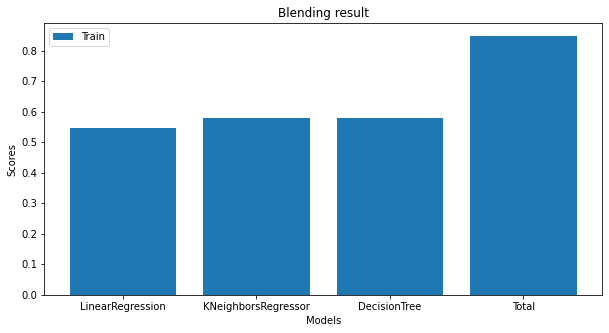

In [51]:
plt.figure(figsize=(10,5))
plt.bar(range(len(score_hold_out)), score_hold_out.values(), align="center", label='Train')
plt.xticks(range(len(score_hold_out)), list(score_hold_out.keys()))
plt.autoscale
plt.title('Blending result')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.legend()

### Видим, что среднее значение score, полученное на основе блендинга, действительно, намного превышает score отдельных моделей, которые входили в его базовые модели.